In [32]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [33]:
degree = 3
n_nodes = 500
rate = 1.
T = 10
dt = 0.01
fprefix = 'testdata/rrg_sis_'

def conversion_function(x):
    ans = [None] * len(x)
    for i in range(len(x)):
        if x[i] == 'S': ans[i] = 0.
        if x[i] == 'I': ans[i] = 1.
    return torch.tensor(ans)


In [34]:
# Generating the network
graph = nx.random_regular_graph(2 * degree, n_nodes)
#graph = nx.barabasi_albert_graph(m=degree, n=n_nodes)
nx.write_edgelist(graph, fprefix + 'edgelist.b')

# Generating the time series
continue_simu = False
iter_max = 100
i = 0
num_sample = 10000

#if os.path.exists(fprefix + '_states.b'):
#    os.remove(fprefix + '_states.b')
data = {}
idx = 0
while(i < num_sample):
    data[idx] = []
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt, filename=None,
                                    full_data_mode=True, overwrite=True)
    t = 0
    while(t < T and sisnet.continue_simu and i < num_sample):
        t += dt
        sisnet.update(record=False)
        i += 1
        data[idx].append(sisnet.activity)
    idx += 1

f = open(fprefix + '_states.b', 'wb')
pickle.dump(data, f)
f.close()

%reset_selective -f data

In [35]:
dataset = dl.Markov_Dataset(fprefix + '_states.b', conversion_function=conversion_function)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
len(dataset)

9990

In [87]:
n_hidden = [1024,1024]
n_embedding = 800
optimizer = lambda p: torch.optim.Adam(p, lr=1e-2, weight_decay=1e-3)
use_cuda = True

markov_cvae = dl.Markov_Complete_CVAE(n_nodes, n_hidden, n_embedding, optimizer=optimizer, use_cuda=use_cuda)

In [88]:
new_lr = 1e-3
for g in markov_cvae.optimizer.param_groups:
    g['lr'] = new_lr

In [89]:
markov_cvae.fit(train_dataset, val_dataset, epochs=50, batch_size=128)

Epoch 0 - Training Loss: 240.9014 ± 4.10 - Validation Loss: 240.8552 ± 5.06 - Training time: 1.8171 - New best
Epoch 1 - Training Loss: 206.9013 ± 4.42 - Validation Loss: 206.9345 ± 4.43 - Training time: 1.7451 - New best
Epoch 2 - Training Loss: 165.9599 ± 4.06 - Validation Loss: 167.7040 ± 4.02 - Training time: 1.7616 - New best
Epoch 3 - Training Loss: 126.4916 ± 3.70 - Validation Loss: 129.5573 ± 3.68 - Training time: 1.7434 - New best
Epoch 4 - Training Loss: 98.4222 ± 3.18 - Validation Loss: 102.3901 ± 2.92 - Training time: 1.7512 - New best
Epoch 5 - Training Loss: 79.6499 ± 2.90 - Validation Loss: 84.4242 ± 2.36 - Training time: 1.7527 - New best
Epoch 6 - Training Loss: 66.5773 ± 2.77 - Validation Loss: 71.9588 ± 1.88 - Training time: 1.7402 - New best
Epoch 7 - Training Loss: 56.4174 ± 2.61 - Validation Loss: 62.1161 ± 1.97 - Training time: 1.7440 - New best
Epoch 8 - Training Loss: 49.3148 ± 2.48 - Validation Loss: 55.5649 ± 1.67 - Training time: 1.7514 - New best
Epoch 9 - 

In [90]:
def test_model(learned_model, dataset):
    init_states = dataset[0][0]
    #T = len(dataset)
    t = 0
    learned_states, z, passed_states = learned_model.predict(init_states, batch_size=2)
    learned_avg = [np.mean(learned_states)]
    while(t < T):
        t += dt
        
        learned_states, z, passed_states = learned_model.predict(passed_states, batch_size=2)
        learned_states = torch.bernoulli(torch.tensor(learned_states[0]))
        passed_states = learned_states
        learned_avg.append(np.mean(learned_states.numpy()))
    
    return learned_avg

def show_dataset(dataset):
    avg = []
#     for i in range(len(dataset)):
#         x = dataset[i][0].numpy()
#         avg.append(np.mean(x))
    t = 0
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt,
                                    filename=None,
                                    full_data_mode=False,
                                    overwrite=True)
    while t < T:
        t += dt
        sisnet.update(record=False)
        avg_state, std_state = sisnet.get_avg_activity()
        avg.append(avg_state['I'])
    return avg


In [91]:
null_cvae = dl.Markov_Complete_CVAE(n_nodes, n_hidden, n_embedding, optimizer=optimizer, use_cuda=use_cuda)

avg_ts = show_dataset(dataset)
null_ts = test_model(null_cvae, dataset)
trained_ts = test_model(markov_cvae, dataset)


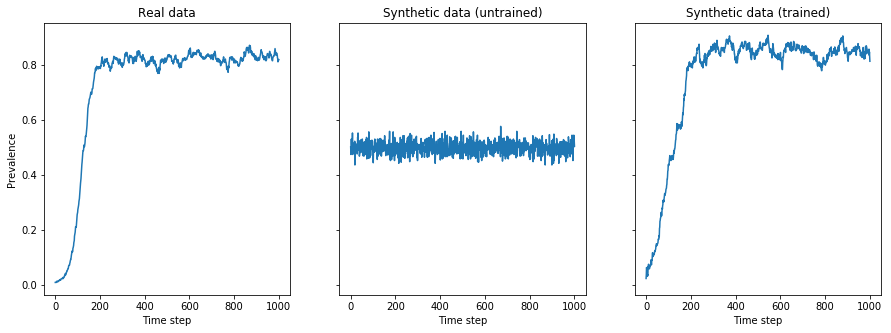

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

ax[0].plot(avg_ts)
ax[0].set_title('Real data')
ax[0].set_ylabel('Prevalence')
ax[0].set_xlabel('Time step')

ax[1].plot(null_ts)
ax[1].set_title('Synthetic data (untrained)')
ax[1].set_xlabel('Time step')

ax[2].plot(trained_ts)
ax[2].set_title('Synthetic data (trained)')
ax[2].set_xlabel('Time step')

fig.savefig(f'fig/png/naive_rrgsis_d{degree}_n{n_nodes}_rate{rate}.png')
fig.savefig(f'fig/pdf/naive_rrgsis_d{degree}_n{n_nodes}_rate{rate}.pdf')
plt.show()